In [1]:
from pymongo import MongoClient
import pprint

import pandas as pd
import matplotlib.pyplot as plt

import requests

from bs4 import BeautifulSoup

import json
import datetime
import calendar
import time
import numpy as np
import scipy.stats as stats

In [2]:
#  Connect to the hosted MongoDB instance
client = MongoClient()

In [3]:
# Access already existing database
db = client['capstone1_bball_reference']

In [4]:
# Access already existing collection in database
all_seasons = db['all_seasons']

In [5]:
actual_links = db.all_seasons.distinct("link")

## Get HTML pages from MongoDB and parse with Beautiful Soup

In [6]:
def parse_to_df(links, starting_season,ending_season):
    
    date = []
    visiting = []
    visiting_score = []
    home = []
    home_score = []
    season = []
    notes = []
    
    for i,link in enumerate(links):
        
        if starting_season <= int(link.split("_")[1]) <= ending_season:
        
            sub_season = all_seasons.find_one({'link':link})['html']
            soup = BeautifulSoup(sub_season,'html.parser')

            for i,game in enumerate(soup.find_all('tr')):
                if game.a != None: #skips the chart label rows
                    datestring = game.find('a').text[5:]
                    dt = datetime.datetime.strptime(datestring,'%b %d, %Y') #change datestring to datetime object
                    date.append(dt)
                    visiting.append(game.find_all('td','left')[0].text)
                    home.append(game.find_all('td','left')[1].text)
                    season.append(soup.find_all('div','inactive')[0].find('li','index').text.rstrip())
                    notes.append(game.find_all('td','left')[-1].text)
                    if len(soup.find_all('col'))==10: #takes care of the different column counts 
                        if (game.find_all('td','right')[1].text) != '': #accommodates for games that were scheduled but never played have have no scores
                            visiting_score.append(int(game.find_all('td','right')[1].text))
                            home_score.append(int(game.find_all('td','right')[2].text))
                        else: 
                            visiting_score.append(0)
                            home_score.append(0)
                    else:
                        if (game.find_all('td','right')[0].text) != '':
                            visiting_score.append(int(game.find_all('td','right')[0].text))
                            home_score.append(int(game.find_all('td','right')[1].text))
                        else: 
                            visiting_score.append(0)
                            home_score.append(0)
                
    df = pd.DataFrame({'date':date,'season':season,'visiting_team':visiting,'visiting_score':visiting_score,
                  'home_team':home, 'home_score':home_score, 'notes':notes})
    return df

In [43]:
df = parse_to_df(actual_links, 2010, 2019)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12897 entries, 0 to 12896
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            12897 non-null  datetime64[ns]
 1   season          12897 non-null  object        
 2   visiting_team   12897 non-null  object        
 3   visiting_score  12897 non-null  int64         
 4   home_team       12897 non-null  object        
 5   home_score      12897 non-null  int64         
 6   notes           12897 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 705.4+ KB


In [45]:
df.head()

,date,season,visiting_team,visiting_score,home_team,home_score,notes
0,2010-04-01,2009-10 NBA Season,Orlando Magic,97,Dallas Mavericks,82,
1,2010-04-01,2009-10 NBA Season,Portland Trail Blazers,92,Denver Nuggets,109,
2,2010-04-02,2009-10 NBA Season,Milwaukee Bucks,86,Charlotte Bobcats,87,
3,2010-04-02,2009-10 NBA Season,Miami Heat,105,Indiana Pacers,96,
4,2010-04-02,2009-10 NBA Season,Chicago Bulls,95,Washington Wizards,87,


Drop rows with notes (these rows are where games are played elsewhere - not at either teams' arenas) and rows with 0's as scores (these games were scheduled but have not been played)

In [46]:
df[df.notes!='']['notes'].count()

17

In [47]:
df[df.visiting_score == 0]['visiting_score'].count()

7

In [48]:
filtered = df[(df.notes=='') & (df.visiting_score != 0)] # 10 seasons and 12873 played that we are considering
filtered

,date,season,visiting_team,visiting_score,home_team,home_score,notes
0,2010-04-01,2009-10 NBA Season,Orlando Magic,97,Dallas Mavericks,82,
1,2010-04-01,2009-10 NBA Season,Portland Trail Blazers,92,Denver Nuggets,109,
2,2010-04-02,2009-10 NBA Season,Milwaukee Bucks,86,Charlotte Bobcats,87,
3,2010-04-02,2009-10 NBA Season,Miami Heat,105,Indiana Pacers,96,
4,2010-04-02,2009-10 NBA Season,Chicago Bulls,95,Washington Wizards,87,
...,...,...,...,...,...,...,...
12885,2018-10-31,2018-19 NBA Season,Utah Jazz,125,Minnesota Timberwolves,128,
12886,2018-10-31,2018-19 NBA Season,Indiana Pacers,107,New York Knicks,101,
12887,2018-10-31,2018-19 NBA Season,New Orleans Pelicans,121,Golden State Warriors,131,
12888,2018-10-31,2018-19 NBA Season,Dallas Mavericks,113,Los Angeles Lakers,114,


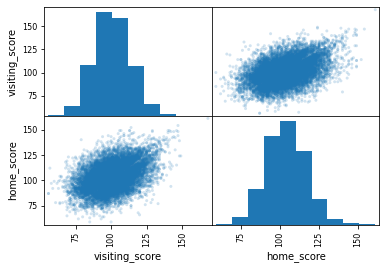

In [50]:
pd.plotting.scatter_matrix(filtered, alpha = 0.2);

At first glance at the histograms it looks like majority of the scores of the visiting teams are just left of 100 points vs. scores of the home teams are just right of 100. They look normally distributed.

## Figure out how many home wins vs visitor wins there are by season and graph it

Approach - create two new columns, home_win and visitor_win, and assign a 1 to the column depending on the winner of the game. This will allow me to do a group by season and sum up the wins per column 

In [51]:
filtered['home_win'] = np.where(filtered['home_score']>filtered['visiting_score'], 1, 0 )

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
filtered['visitor_win'] = np.where(filtered['visiting_score']>filtered['home_score'], 1, 0 )

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
filtered

,date,season,visiting_team,visiting_score,home_team,home_score,notes,home_win,visitor_win
0,2010-04-01,2009-10 NBA Season,Orlando Magic,97,Dallas Mavericks,82,,0,1
1,2010-04-01,2009-10 NBA Season,Portland Trail Blazers,92,Denver Nuggets,109,,1,0
2,2010-04-02,2009-10 NBA Season,Milwaukee Bucks,86,Charlotte Bobcats,87,,1,0
3,2010-04-02,2009-10 NBA Season,Miami Heat,105,Indiana Pacers,96,,0,1
4,2010-04-02,2009-10 NBA Season,Chicago Bulls,95,Washington Wizards,87,,0,1
...,...,...,...,...,...,...,...,...,...
12885,2018-10-31,2018-19 NBA Season,Utah Jazz,125,Minnesota Timberwolves,128,,1,0
12886,2018-10-31,2018-19 NBA Season,Indiana Pacers,107,New York Knicks,101,,0,1
12887,2018-10-31,2018-19 NBA Season,New Orleans Pelicans,121,Golden State Warriors,131,,1,0
12888,2018-10-31,2018-19 NBA Season,Dallas Mavericks,113,Los Angeles Lakers,114,,1,0


In [17]:
total_home_wins = filtered[filtered.home_win==1]['home_team'].count()
total_home_wins

7626

In [18]:
total_games = filtered.shape[0]
total_games

12873

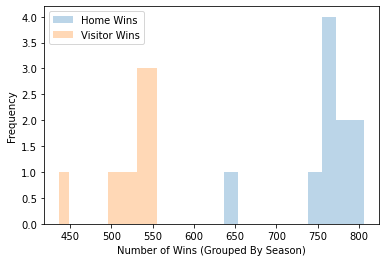

In [19]:
home_wins = filtered.groupby('season')[['home_team','home_win']].sum()
visitor_wins = filtered.groupby('season')[['visiting_team','visitor_win']].sum()
fig, ax = plt.subplots()
ax.hist(home_wins,alpha=0.3,label="Home Wins")
ax.hist(visitor_wins,alpha=0.3,label="Visitor Wins")
ax.set_xlabel('Number of Wins (Grouped By Season)')
ax.set_ylabel('Frequency')
ax.legend();

## One Sample Test of Population Proportions
* Scientific Question - Is home court advantage real?
* Null Hypothesis: There is no such thing as a home court advantage. Home teams win 50% of the games. p =0.5
* Alternative Hypothesis: There is such a thing as home court advantage. Home teams win more than 50% of the games.
* Test statistic: number of games won by home teams (observed = 7626 home wins/12873)
* Significance level: 0.05
* Distribution of the null
    * Binomial where n = 12873 games p = 0.5

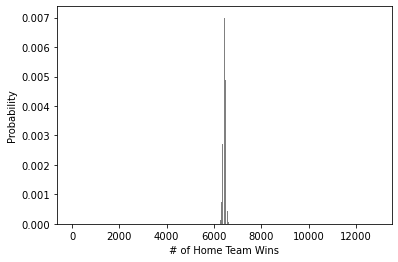

In [20]:
binomial = stats.binom(n=total_games, p=0.5)

fig, ax = plt.subplots()
bars = ax.bar(range(total_games+1), [binomial.pmf(i) for i in range(total_games+1)], color="grey")
ax.set_xlabel('# of Home Team Wins')
ax.set_ylabel('Probability');

In [21]:
prob_equal_or_more_extreme = 1 - binomial.cdf(total_home_wins-1)
print("Probability of Observing Data More Equal or More Extreme than Actual: {:2.2}".format(prob_equal_or_more_extreme))

Probability of Observing Data More Equal or More Extreme than Actual: 1.1e-16


Reject the null

## Use the normal distribution to approximate  binomial probabilities
Binomial(12873,0.5) = ~ N(12873 x 0.5, $\sqrt{12873 x 0.5 x 0.5}$

Variance of Binomial distribution = variance of Normal distribution

variance = nP(1-P)

std = $\sqrt{nP(1-P)}$

Note we are using known equations for the expected value and variance of the normal distribution above. This approximation is helpful because it is both very accurate and more computationally efficient to consider a normal distribution than a binomial when there are a large number of trials.

Now in order to test the same hypothesis as the previous example we could calculate our p-value using the normal distribution as our null instead of the binomial.

In [22]:
norm = stats.norm(loc = total_games*0.5, scale = np.sqrt(total_games*0.5*0.5))
1- norm.cdf(total_home_wins)

0.0

In [23]:
norm.pdf(8650)

0.0

Reject the null

Text(0.5, 0, 'Number of Home Team Wins')

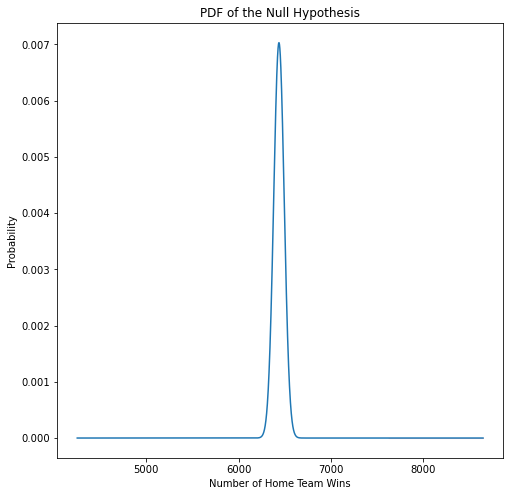

In [24]:

fig, ax = plt.subplots(figsize=(8,8))
n, p = total_games,0.5
x = np.arange(4250,8650)
ax.plot(x, norm.pdf(x))
ax.fill_between(x, norm.pdf(x), 0,
                   where=((x >= total_home_wins)),
                   color="red", alpha=0.2)
ax.set_title("PDF of the Null Hypothesis")
ax.set_ylabel("Probability")
ax.set_xlabel("Number of Home Team Wins")


Null: There is no home court advantage for the knicks. Knicks home win rate = Knicks away win rate

Alternative: There is home court advantage for the knicks. Knicks home win rate > Knicks away win rate

In [25]:
total_knicks = filtered[(filtered.home_team == 'New York Knicks') | (filtered.visiting_team == 'New York Knicks')]
total_knicks

,date,season,visiting_team,visiting_score,home_team,home_score,notes,home_win,visitor_win
10,2010-04-02,2009-10 NBA Season,New York Knicks,117,Golden State Warriors,128,,1,0
28,2010-04-04,2009-10 NBA Season,New York Knicks,113,Los Angeles Clippers,107,,0,1
33,2010-04-06,2009-10 NBA Season,Boston Celtics,101,New York Knicks,104,,1,0
38,2010-04-07,2009-10 NBA Season,New York Knicks,105,Indiana Pacers,113,,1,0
54,2010-04-09,2009-10 NBA Season,New York Knicks,103,Orlando Magic,118,,1,0
...,...,...,...,...,...,...,...,...,...
12821,2018-10-22,2018-19 NBA Season,New York Knicks,113,Milwaukee Bucks,124,,1,0
12833,2018-10-24,2018-19 NBA Season,New York Knicks,87,Miami Heat,110,,1,0
12847,2018-10-26,2018-19 NBA Season,Golden State Warriors,128,New York Knicks,100,,0,1
12869,2018-10-29,2018-19 NBA Season,Brooklyn Nets,96,New York Knicks,115,,1,0


In [26]:
total_knicks_season = total_knicks.groupby('season')['season','home_win','visitor_win'].sum()
total_knicks_season

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,home_win,visitor_win
season,,
2009-10 NBA Season,48,34
2010-11 NBA Season,47,39
2011-12 NBA Season,45,26
2012-13 NBA Season,57,36
2013-14 NBA Season,42,40
2014-15 NBA Season,43,38
2015-16 NBA Season,45,37
2016-17 NBA Season,48,34
2017-18 NBA Season,50,32


In [27]:
knicks_home_wins = total_knicks.groupby('season')[['season','home_win']].sum()
knicks_home_wins

,home_win
season,
2009-10 NBA Season,48
2010-11 NBA Season,47
2011-12 NBA Season,45
2012-13 NBA Season,57
2013-14 NBA Season,42
2014-15 NBA Season,43
2015-16 NBA Season,45
2016-17 NBA Season,48
2017-18 NBA Season,50


In [28]:
knicks_away_wins = total_knicks.groupby('season')[['season','visitor_win']].sum()
knicks_away_wins

,visitor_win
season,
2009-10 NBA Season,34
2010-11 NBA Season,39
2011-12 NBA Season,26
2012-13 NBA Season,36
2013-14 NBA Season,40
2014-15 NBA Season,38
2015-16 NBA Season,37
2016-17 NBA Season,34
2017-18 NBA Season,32


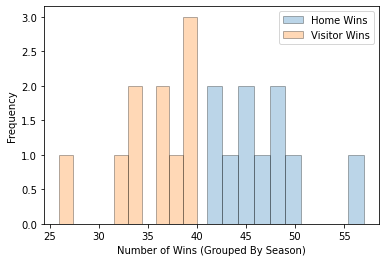

In [29]:
fig, ax = plt.subplots()
ax.hist(knicks_home_wins,alpha=0.3,label="Home Wins",edgecolor="black")
ax.hist(knicks_away_wins,alpha=0.3,label="Visitor Wins", edgecolor = "black")
ax.set_xlabel('Number of Wins (Grouped By Season)')
ax.set_ylabel('Frequency')
ax.legend();

In [30]:
total_knicks_games = total_knicks.shape[0]
total_knicks_games

822

In [31]:
knicks_home_wins['win_rate'] = knicks_home_wins.home_win / total_knicks_games
knicks_home_wins

,home_win,win_rate
season,,
2009-10 NBA Season,48,0.058394
2010-11 NBA Season,47,0.057178
2011-12 NBA Season,45,0.054745
2012-13 NBA Season,57,0.069343
2013-14 NBA Season,42,0.051095
2014-15 NBA Season,43,0.052311
2015-16 NBA Season,45,0.054745
2016-17 NBA Season,48,0.058394
2017-18 NBA Season,50,0.060827


In [32]:
knicks_away_wins['win_rate'] = knicks_away_wins.visitor_win / total_knicks_games

In [33]:
x = knicks_home_wins['win_rate']
x

season
2009-10 NBA Season    0.058394
2010-11 NBA Season    0.057178
2011-12 NBA Season    0.054745
2012-13 NBA Season    0.069343
2013-14 NBA Season    0.051095
2014-15 NBA Season    0.052311
2015-16 NBA Season    0.054745
2016-17 NBA Season    0.058394
2017-18 NBA Season    0.060827
2018-19 NBA Season    0.049878
Name: win_rate, dtype: float64

In [34]:
y = knicks_away_wins['win_rate']
y

season
2009-10 NBA Season    0.041363
2010-11 NBA Season    0.047445
2011-12 NBA Season    0.031630
2012-13 NBA Season    0.043796
2013-14 NBA Season    0.048662
2014-15 NBA Season    0.046229
2015-16 NBA Season    0.045012
2016-17 NBA Season    0.041363
2017-18 NBA Season    0.038929
2018-19 NBA Season    0.048662
Name: win_rate, dtype: float64

In [79]:
stats.ttest_ind(knicks_home_wins['win_rate'],knicks_away_wins['win_rate'],equal_var =False)

Ttest_indResult(statistic=5.478735076410081, pvalue=3.3945629412192126e-05)

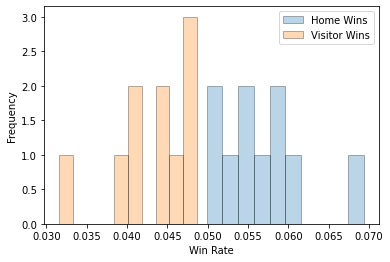

In [36]:
fig, ax = plt.subplots()
ax.hist(x,alpha=0.3,label="Home Wins",edgecolor="black")
ax.hist(y,alpha=0.3,label="Visitor Wins", edgecolor = "black")
ax.set_xlabel('Win Rate')
ax.set_ylabel('Frequency')
ax.legend();

In [68]:
total_nets = filtered[(filtered.home_team == 'New Jersey Nets') | (filtered.visiting_team == 'New Jersey Nets')|(filtered.home_team == 'Brooklyn Nets') | (filtered.visiting_team == 'Brooklyn Nets')]
total_nets

,date,season,visiting_team,visiting_score,home_team,home_score,notes,home_win,visitor_win
14,2010-04-03,2009-10 NBA Season,New Orleans Hornets,87,New Jersey Nets,115,,1,0
26,2010-04-04,2009-10 NBA Season,New Jersey Nets,99,Washington Wizards,109,,1,0
44,2010-04-07,2009-10 NBA Season,New Jersey Nets,89,Milwaukee Bucks,108,,1,0
61,2010-04-09,2009-10 NBA Season,Chicago Bulls,116,New Jersey Nets,127,,1,0
68,2010-04-10,2009-10 NBA Season,New Jersey Nets,102,Indiana Pacers,115,,1,0
...,...,...,...,...,...,...,...,...,...
12832,2018-10-24,2018-19 NBA Season,Brooklyn Nets,102,Cleveland Cavaliers,86,,0,1
12851,2018-10-26,2018-19 NBA Season,Brooklyn Nets,115,New Orleans Pelicans,117,,1,0
12862,2018-10-28,2018-19 NBA Season,Golden State Warriors,120,Brooklyn Nets,114,,0,1
12869,2018-10-29,2018-19 NBA Season,Brooklyn Nets,96,New York Knicks,115,,1,0


In [69]:
total_nets_season = total_nets.groupby('season')['season','home_win','visitor_win'].sum()
total_nets_season

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,home_win,visitor_win
season,,
2009-10 NBA Season,45,37
2010-11 NBA Season,53,27
2011-12 NBA Season,29,37
2012-13 NBA Season,48,41
2013-14 NBA Season,61,32
2014-15 NBA Season,46,42
2015-16 NBA Season,48,34
2016-17 NBA Season,47,35
2017-18 NBA Season,42,38


In [70]:
nets_home_wins = total_nets.groupby('season')[['season','home_win']].sum()
nets_home_wins

,home_win
season,
2009-10 NBA Season,45
2010-11 NBA Season,53
2011-12 NBA Season,29
2012-13 NBA Season,48
2013-14 NBA Season,61
2014-15 NBA Season,46
2015-16 NBA Season,48
2016-17 NBA Season,47
2017-18 NBA Season,42


In [72]:
nets_away_wins = total_nets.groupby('season')[['season','visitor_win']].sum()
nets_away_wins

,visitor_win
season,
2009-10 NBA Season,37
2010-11 NBA Season,27
2011-12 NBA Season,37
2012-13 NBA Season,41
2013-14 NBA Season,32
2014-15 NBA Season,42
2015-16 NBA Season,34
2016-17 NBA Season,35
2017-18 NBA Season,38


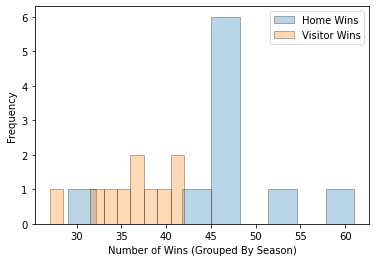

In [73]:
fig, ax = plt.subplots()
ax.hist(nets_home_wins,alpha=0.3,label="Home Wins",edgecolor="black")
ax.hist(nets_away_wins,alpha=0.3,label="Visitor Wins", edgecolor = "black")
ax.set_xlabel('Number of Wins (Grouped By Season)')
ax.set_ylabel('Frequency')
ax.legend();

In [74]:
total_nets_games = total_nets.shape[0]
total_nets_games

829

In [75]:
nets_home_wins['win_rate'] = nets_home_wins.home_win / total_nets_games
nets_home_wins

,home_win,win_rate
season,,
2009-10 NBA Season,45,0.054282
2010-11 NBA Season,53,0.063932
2011-12 NBA Season,29,0.034982
2012-13 NBA Season,48,0.057901
2013-14 NBA Season,61,0.073583
2014-15 NBA Season,46,0.055489
2015-16 NBA Season,48,0.057901
2016-17 NBA Season,47,0.056695
2017-18 NBA Season,42,0.050663


In [77]:
nets_away_wins['win_rate'] = nets_away_wins.visitor_win / total_nets_games
nets_away_wins

,visitor_win,win_rate
season,,
2009-10 NBA Season,37,0.044632
2010-11 NBA Season,27,0.032569
2011-12 NBA Season,37,0.044632
2012-13 NBA Season,41,0.049457
2013-14 NBA Season,32,0.038601
2014-15 NBA Season,42,0.050663
2015-16 NBA Season,34,0.041013
2016-17 NBA Season,35,0.042220
2017-18 NBA Season,38,0.045838


In [80]:
stats.ttest_ind(nets_home_wins['win_rate'],nets_away_wins['win_rate'],equal_var =False)

Ttest_indResult(statistic=3.5202390633231344, pvalue=0.003348496466684705)